In [31]:
import pandas as pd
import matplotlib as mat
from matplotlib.pyplot import plot as plt 
import numpy as np
import statsmodels.api as sm
import sklearn as sk
import pickle
%matplotlib inline 

In [32]:
industry_rollingBeta= pickle.load( open( 'industry_rollingBeta.p', 'rb'))
industry_rollingModel= pickle.load( open( 'M3_rollingModel.p', 'rb'))
industry_factor= pickle.load(open( 'industry_factor.p', 'rb'))
industry_rollingLoading= {}
for k ,val in industry_rollingBeta.items():
    industry_rollingLoading[k]= val[industry_factor[k]]
industry_rollingBetaStd= pickle.load( open('industry_rollingBetaStd.p', 'rb'))

In [57]:
est_date= '2006-03-01'

# This section attemps to estimate OOS 

In [58]:
industry_rollingLoading

{'BusEq':               Mkt-RF       HML       MOM       CMA       RMW       SMB
 1996-03-01  0.956905  0.137427 -0.027039 -1.011672 -0.173602  0.361280
 1997-03-01  1.035949  0.010546 -0.029705 -0.913341 -0.163882  0.280629
 1998-03-01  1.014639  0.093986  0.016569 -1.182763 -0.213450  0.154019
 1999-03-01  0.952427  0.007206  0.103723 -1.299183 -0.307205  0.063942
 2000-03-01  0.954413 -0.197544  0.138987 -1.005437 -0.357130  0.182500
 2001-03-01  0.997375 -0.183463  0.026520 -1.010785 -0.311656  0.132901
 2002-03-01  1.044389 -0.196523 -0.034951 -0.971487 -0.340760  0.145392
 2003-03-01  1.179507 -0.457878 -0.147569 -0.446569 -0.390475  0.076469
 2004-03-01  1.181277 -0.439059 -0.130195 -0.426089 -0.417194  0.084133
 2005-03-01  1.194588 -0.441236 -0.120834 -0.387239 -0.432691  0.086077
 2006-03-01  1.199049 -0.444281 -0.119671 -0.379622 -0.432814  0.086336
 2007-03-01  1.209251 -0.473559 -0.123094 -0.342492 -0.420469  0.088737
 2008-03-01  1.216576 -0.501278 -0.110427 -0.322511 -0.

In [59]:
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf
series= industry_rollingLoading['Enrgy']['HML']

ar_model= AR( endog= series).fit( maxlag= 1)
#plot_acf(ar_model.resid)
ar_model.params
ar_model.resid
ar_model.predict(start='2014-03-01')

2014-03-01    0.301986
2015-03-01    0.304893
2016-03-01    0.331183
2017-03-01    0.365501
Freq: AS-MAR, dtype: float64

In [60]:
ar_model.fittedvalues.index[-1]

'2017-03-01'

In [61]:
from OU_process import OU_smoothing

tmp_series= pd.concat( [industry_rollingLoading['Enrgy']['HML'], industry_rollingBetaStd['Enrgy']['HML']], axis=1)
tmp_series.columns= ['value', 'std']

tmp_series
OU_smooth= OU_smoothing( series= tmp_series, est_date= est_date)

In [62]:
OU_smooth['OU_smoothed_res']

,OU_1period_pred,OU_1period_pred_variance,obs,obs_variance,OU_smoothed_obs
2006-03-01,0.455320,0.002395,0.534420,0.009603,0.471112
2007-03-01,0.452261,0.002252,0.539492,0.009418,0.469098
2008-03-01,0.451999,0.002245,0.491527,0.009659,0.459454
2009-03-01,0.450741,0.002222,0.292827,0.008363,0.417597
2010-03-01,0.445285,0.002331,0.242857,0.007330,0.396437
2011-03-01,0.442527,0.002518,0.260461,0.006962,0.394171
2012-03-01,0.442231,0.002543,0.278459,0.006885,0.398059
2013-03-01,0.442738,0.002500,0.278940,0.006657,0.398016
2014-03-01,0.442733,0.002501,0.282734,0.006374,0.397648
2015-03-01,0.442685,0.002505,0.317036,0.006347,0.407132


In [51]:
OU_smooth['OU_fitted']

{'ar_model': <statsmodels.tsa.ar_model.ARResultsWrapper at 0x1081b6748>,
 'lam': 2.0374789737020289,
 'mu': 0.4494355122360977,
 'sigma': 0.090926676309731946}

In [73]:
OU_est_date= '2006-03-01'

industry_rollingLoading_OUSmoothed= {}
industry_OUfitted= {}

for ind, val  in industry_rollingLoading.items():  
    beta_fittedModel= {}
    beta_smoothed= {} # key is factor name 
    
    for f in val.columns: 
        tmp_series= pd.concat([val[f], industry_rollingBetaStd[ind][f]], axis =1)
        tmp_series.columns= ['value', 'std']
        OU_res= OU_smoothing(series= tmp_series, est_date=OU_est_date)
        beta_fittedModel[ f]= OU_res[ 'OU_fitted']
        beta_smoothed[ f]= OU_res['OU_smoothed_res']['OU_smoothed_obs']
#         print(ind)
#         print(f)
#         print(OU_res['OU_fitted'])
#         print(OU_res['OU_smoothed_res'])
        
    
    
    industry_rollingLoading_OUSmoothed[ind]= pd.DataFrame( beta_smoothed)
    industry_OUfitted[ ind]= beta_fittedModel
    
    

    
    

Money
Mkt-RF
{'ar_model': <statsmodels.tsa.ar_model.ARResultsWrapper object at 0x117e177f0>, 'sigma': 0.034630683567009386, 'mu': 1.2492131401990045, 'lam': 0.43897718945905251}
            OU_1period_pred  OU_1period_pred_variance       obs  obs_variance  \
2006-03-01         1.224042                  0.001010  1.193838      0.001891   
2007-03-01         1.226207                  0.000991  1.191693      0.001779   
2008-03-01         1.226422                  0.000989  1.193923      0.001781   
2009-03-01         1.227040                  0.000984  1.178387      0.001630   
2010-03-01         1.223113                  0.001018  1.138916      0.001525   
2011-03-01         1.210648                  0.001163  1.128328      0.001241   
2012-03-01         1.198679                  0.001352  1.138596      0.001131   
2013-03-01         1.195544                  0.001409  1.137226      0.001078   
2014-03-01         1.193310                  0.001452  1.127962      0.000992   
2015-03-01  

/Users/Eric/FF_IndustryFactorExposure/OU_process.py:18: RuntimeWarning: invalid value encountered in log
  lam= - np.log(a)
/Users/Eric/FF_IndustryFactorExposure/OU_process.py:20: RuntimeWarning: invalid value encountered in log
  sigma= resid_std* np.sqrt( -2* np.log(a)/(1-a*a))


Durbl
SMB
{'ar_model': <statsmodels.tsa.ar_model.ARResultsWrapper object at 0x1180f70b8>, 'sigma': 0.056117536232469997, 'mu': 0.18117332886266888, 'lam': 0.28141155066457407}
            OU_1period_pred  OU_1period_pred_variance       obs  obs_variance  \
2006-03-01         0.205787                  0.002737  0.254289      0.005860   
2007-03-01         0.211402                  0.002719  0.263115      0.005599   
2008-03-01         0.216746                  0.002706  0.257131      0.005383   
2009-03-01         0.218216                  0.002702  0.219410      0.005450   
2010-03-01         0.209429                  0.002725  0.326575      0.006106   
2011-03-01         0.229779                  0.002683  0.373428      0.005979   
2012-03-01         0.251438                  0.002680  0.399496      0.006074   
2013-03-01         0.268409                  0.002707  0.395775      0.006321   
2014-03-01         0.275834                  0.002727  0.398445      0.006224   
2015-03-01    

{'ar_model': <statsmodels.tsa.ar_model.ARResultsWrapper object at 0x117d15358>, 'sigma': 0.037433315219398668, 'mu': 0.24778704019103326, 'lam': 0.33608043887140027}
            OU_1period_pred  OU_1period_pred_variance       obs  obs_variance  \
2006-03-01         0.252850                  0.001170  0.257702      0.003007   
2007-03-01         0.252376                  0.001172  0.258173      0.002971   
2008-03-01         0.252238                  0.001172  0.269479      0.002895   
2009-03-01         0.254519                  0.001165  0.271533      0.002810   
2010-03-01         0.256162                  0.001161  0.218259      0.002631   
2011-03-01         0.245480                  0.001198  0.235139      0.002492   
2012-03-01         0.243739                  0.001206  0.227090      0.002382   
2013-03-01         0.240897                  0.001219  0.220807      0.002317   
2014-03-01         0.237915                  0.001234  0.221923      0.002241   
2015-03-01         0.236

Chems
RMW
{'ar_model': <statsmodels.tsa.ar_model.ARResultsWrapper object at 0x11806fef0>, 'sigma': 0.071745617705710946, 'mu': 0.4518570731250252, 'lam': 0.48001081338635193}
            OU_1period_pred  OU_1period_pred_variance       obs  obs_variance  \
2006-03-01         0.457887                  0.003951  0.460732      0.003430   
2007-03-01         0.456531                  0.003939  0.452938      0.003320   
2008-03-01         0.453543                  0.003914  0.449202      0.003452   
2009-03-01         0.451473                  0.003897  0.437479      0.003367   
2010-03-01         0.446974                  0.003863  0.454103      0.003285   
2011-03-01         0.451219                  0.003895  0.447189      0.003203   
2012-03-01         0.450094                  0.003887  0.448682      0.003061   
2013-03-01         0.450277                  0.003888  0.445929      0.002949   
2014-03-01         0.449350                  0.003881  0.441870      0.002792   
2015-03-01     

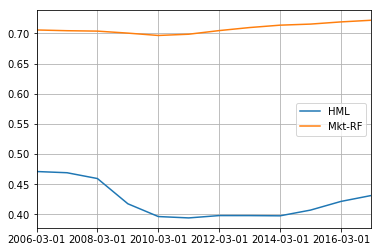

In [78]:
industry_rollingLoading_OUSmoothed['Enrgy'].plot(grid= True)

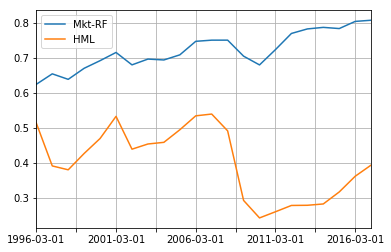

In [79]:
industry_rollingLoading['Enrgy'].plot(grid=True)

In [80]:
industry_rollingLoading_OUSmoothed

{'BusEq':                  CMA       HML       MOM    Mkt-RF       RMW       SMB
 2006-03-01 -0.381381 -0.449496 -0.116833  1.201151 -0.442592  0.093686
 2007-03-01 -0.350181 -0.468502 -0.118609  1.209384 -0.447164  0.096624
 2008-03-01 -0.328375 -0.491457 -0.109697  1.216707 -0.447616  0.097074
 2009-03-01 -0.332725 -0.525185 -0.101498  1.182795 -0.443081  0.101983
 2010-03-01 -0.307927 -0.530590 -0.081153  1.188129 -0.434053  0.113474
 2011-03-01 -0.307791 -0.523091 -0.074758  1.192891 -0.426176  0.118182
 2012-03-01 -0.317940 -0.519497 -0.078884  1.177031 -0.423986  0.110894
 2013-03-01 -0.332783 -0.521686 -0.079346  1.167581 -0.419349  0.111825
 2014-03-01 -0.340818 -0.519705 -0.082010  1.162000 -0.415628  0.110585
 2015-03-01 -0.328786 -0.516537 -0.085305  1.159151 -0.413844  0.096951
 2016-03-01 -0.308069 -0.512271 -0.092021  1.154170 -0.413033  0.083847
 2017-03-01 -0.345414 -0.497198 -0.088412  1.153899 -0.408641  0.078534,
 'Chems':                  CMA    Mkt-RF       RMW
 20

In [88]:
a= np.array([[1,3],[4,5]])

b= np.array([[2,3],[1,2]])

In [95]:
a*b

array([[ 2,  9],
       [ 4, 10]])

In [97]:
np.sum(a*b, axis=1)

array([11, 14])